In [1]:
using EvalMetrics
using Plots

using Pickle
using PyCall
using PrettyTables
using Logging
using Printf

Logging.disable_logging(Logging.Warn)

include("Utils.jl")

label_names = ["Quick Sort", "Merge Sort", "Selection Sort", "Insertion Sort", "Bubble Sort",
    "Linear Search", "Binary Search", "Linked List", "Hashmap"]

9-element Vector{String}:
 "Quick Sort"
 "Merge Sort"
 "Selection Sort"
 "Insertion Sort"
 "Bubble Sort"
 "Linear Search"
 "Binary Search"
 "Linked List"
 "Hashmap"

In [2]:
preds = [Matrix(load_pickle("focal/prediction_$i.pkl")') for i in 0:9]
reals = [Matrix(load_pickle("focal/real_$i.pkl")') for i in 0:9];

targets = hcat(reals...)
predictions = hcat(preds...);

### Confusion Matrix
We create a confusion matrix for each threshold in $[0.25, 0.40, 0.50, 0.60, 0.75]$

In [3]:
thresholds = [0.25, 0.4, 0.5, 0.6, 0.75]

metrics = ["True Positive", "True Negative", "False Positive", "False Negative",
    "Recall/Sensitivity", "Precision", "F1-Score", "Accuracy", "Specificity"]
headers = [" ", metrics...]

for threshold ∈ thresholds
    println("Binary Decision Boundary: $threshold")
    
    data = Matrix{Any}(undef, length(label_names), length(headers))
    
    for (idx, label) in enumerate(label_names)
        #ACTUAL POSITIVES, ACTUAL NEGATIVES, TP, TN, FN, FP
        conf = ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)
        
        data[idx, 1] = label
        data[idx, 2] = true_positive(conf)
        data[idx, 3] = true_negative(conf)
        data[idx, 4] = false_positive(conf)
        data[idx, 5] = false_negative(conf)
        data[idx, 6] = recall(conf)
        data[idx, 7] = precision(conf)
        data[idx, 8] = f1_score(conf)
        data[idx, 9] = accuracy(conf)
        data[idx, 10] = specificity(conf)
        
    end
    
    pretty_table(data, header=headers)
end

Binary Decision Boundary: 0.25
┌────────────────┬───────────────┬───────────────┬────────────────┬────────────────┬────────────────────┬───────────┬──────────┬──────────┬─────────────┐
│                │ True Positive │ True Negative │ False Positive │ False Negative │ Recall/Sensitivity │ Precision │ F1-Score │ Accuracy │ Specificity │
├────────────────┼───────────────┼───────────────┼────────────────┼────────────────┼────────────────────┼───────────┼──────────┼──────────┼─────────────┤
│     Quick Sort │           755 │          4424 │            272 │              3 │           0.996042 │  0.735151 │ 0.845938 │ 0.949578 │    0.942078 │
│     Merge Sort │           885 │          3932 │            636 │              1 │           0.998871 │  0.581854 │ 0.735355 │ 0.883205 │    0.860771 │
│ Selection Sort │           661 │          4419 │            372 │              2 │           0.996983 │  0.639884 │ 0.779481 │ 0.931426 │    0.922354 │
│ Insertion Sort │           819 │          4

### Multilabel Metrics

In [4]:
thresholds = [0.25, 0.4, 0.5, 0.6, 0.75]

metrics = ["Micro-F1", "Micro-Recall", "Micro-Precision", "Macro-F1", "Macro-Recall", "Macro-Precision", "Subset Accuracy", "Hamming Loss"]
headers = ["Threshold", thresholds...]

data = Matrix{Any}(undef, length(metrics), length(headers))

for (j, metric) ∈ enumerate(metrics)
    data[j, 1] = metric
end

for (idx, threshold) ∈ enumerate(thresholds)
    
    f1s1 = f1s([confusion(targets[idx, :], predictions[idx, :], threshold) for idx in 1:length(label_names)])
    ms   = other_metrics(targets, predictions, threshold)
    
    data[1, idx + 1] = f1s1[:micro_f1]
    data[2, idx + 1] = f1s1[:micro_recall]
    data[3, idx + 1] = f1s1[:micro_precision]
    data[4, idx + 1] = f1s1[:macro_f1]
    data[5, idx + 1] = f1s1[:macro_recall]
    data[6, idx + 1] = f1s1[:macro_precision]
    data[7, idx + 1] = @sprintf("%.3f%%", ms[:subset_acc] * 100)
    data[8, idx + 1] = ms[:hamming]
end
pretty_table(data, header=headers)

┌─────────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│       Threshold │      0.25 │       0.4 │       0.5 │       0.6 │      0.75 │
├─────────────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│        Micro-F1 │  0.763294 │  0.915346 │  0.945325 │  0.952762 │  0.916274 │
│    Micro-Recall │  0.994194 │  0.982084 │  0.969476 │  0.946914 │   0.85418 │
│ Micro-Precision │  0.619432 │  0.857101 │  0.922348 │  0.958683 │  0.988102 │
│        Macro-F1 │  0.770553 │  0.921791 │  0.948959 │  0.954432 │  0.916321 │
│    Macro-Recall │  0.994585 │  0.982929 │  0.970756 │  0.948505 │  0.854735 │
│ Macro-Precision │  0.628894 │  0.867814 │  0.928119 │  0.960433 │  0.987472 │
│ Subset Accuracy │   59.168% │   84.232% │   89.861% │   91.768% │   85.625% │
│    Hamming Loss │ 0.0757242 │ 0.0223078 │ 0.0137717 │ 0.0115308 │ 0.0191704 │
└─────────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘


### Curves
Here, we compute the ROC Curve and the PR Curve and its AUC

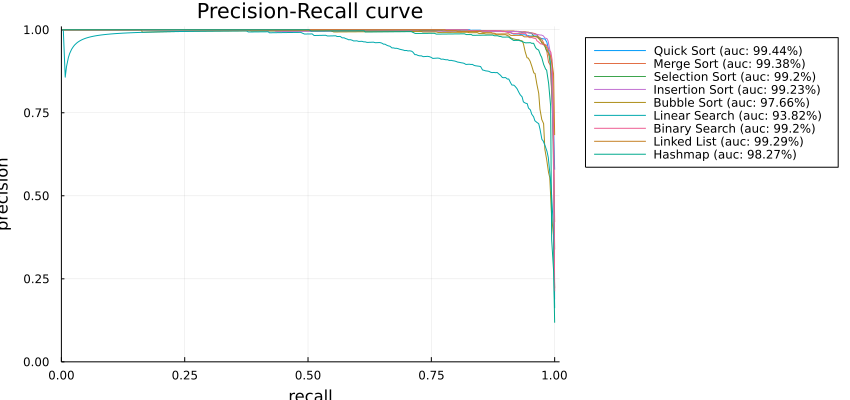

In [5]:
p = plot(size=(850, 400))

for (idx, label) ∈ enumerate(label_names)
    prplot!(p, targets[idx, :], predictions[idx, :], label=label, fill=false, legend=:outertopright)
end
p

For finding the optimal thresholds, we maximize the F1-score for each label

In [6]:
thresholds = 0.0:0.001:1.0 |> collect

change_nan(s) = isnan(s) ? 0 : s

for (idx, label) ∈ enumerate(label_names)
    f1_scores = thresholds .|> threshold -> f1_score(ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)) .|> change_nan
    jdx = argmax(f1_scores)
    decision_boundary = thresholds[jdx]
    println("$label => $decision_boundary | score: $(f1_scores[jdx])")
end

Quick Sort => 0.496 | score: 0.97634691195795
Merge Sort => 0.619 | score: 0.9744753261486103
Selection Sort => 0.572 | score: 0.9712121212121211
Insertion Sort => 0.55 | score: 0.979293544457978
Bubble Sort => 0.543 | score: 0.9506953223767383
Linear Search => 0.587 | score: 0.8784461152882206
Binary Search => 0.591 | score: 0.9683944374209861
Linked List => 0.579 | score: 0.971297359357061
Hashmap => 0.555 | score: 0.9582909460834181


Also, we can find the optimal decision boundaries using the ROC Curve

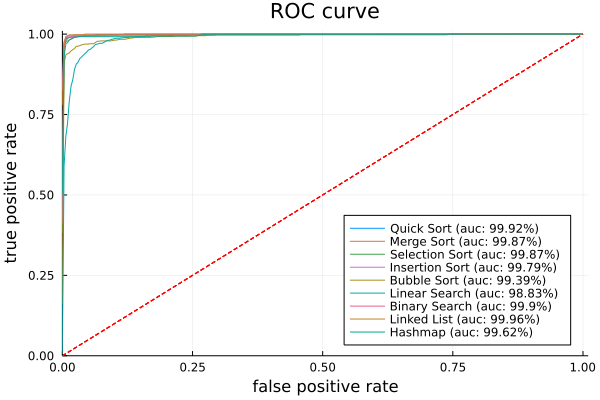

In [7]:
p = plot()

for (idx, label) ∈ enumerate(label_names)
    rocplot!(p, targets[idx, :], predictions[idx, :], label=label, fill=false)
end
p

We can find the optimal threshold using Youden's J Statistic

In [8]:
thresholds = 0.0:0.001:1.0 |> collect

j(sens, spec) = sens + spec - 1

for (idx, label) ∈ enumerate(label_names)
    confusion_matrices = thresholds .|> threshold -> ConfusionMatrix(targets[idx, :], predictions[idx, :], threshold)
    j_scores = confusion_matrices .|> conf -> j(sensitivity(conf), specificity(conf))
    jdx = argmax(j_scores)
    decision_boundary = thresholds[jdx]
    println("$label => $decision_boundary | score: $(j_scores[jdx])")
end

Quick Sort => 0.421 | score: 0.9787569727562446
Merge Sort => 0.508 | score: 0.9706259660885619
Selection Sort => 0.435 | score: 0.9775446231669296
Insertion Sort => 0.456 | score: 0.9823703799714167
Bubble Sort => 0.367 | score: 0.9352062269298669
Linear Search => 0.436 | score: 0.9044241218456821
Binary Search => 0.494 | score: 0.987170373070847
Linked List => 0.367 | score: 0.9848758962293074
Hashmap => 0.358 | score: 0.9702372174870479
